# E-Commerce Price Monitor
A compact variant that reads `clean_books_data.csv`, performs light cleaning, shows a short summary,
plots a horizontal boxplot + histogram, and saves a cleaned CSV with a different filename.


Load CSV

In [1]:

import os
import pandas as pd

CSV_FILE = "clean_books_data.csv"   # must be uploaded to Colab or present in working dir

if not os.path.exists(CSV_FILE):
    raise FileNotFoundError(f"{CSV_FILE} not found. Please upload it to the Colab session.")

raw = pd.read_csv(CSV_FILE)
print("Loaded file. Shape:", raw.shape)
print("Columns:", raw.columns.tolist())
display(raw.head(5))


Loaded file. Shape: (100, 3)
Columns: ['Product Name', 'Price (£)', 'Availability']


,Product Name,Price (£),Availability
0,A Light in the Attic,51.77,In stock
1,Tipping the Velvet,53.74,In stock
2,Soumission,50.10,In stock
3,Sharp Objects,47.82,In stock
4,Sapiens: A Brief History of Humankind,54.23,In stock


##  Light cleaning

In [2]:

import numpy as np

df_friend = raw.copy()

# Normalize column names to simple lowercase underscore format
df_friend.columns = [c.strip().lower().replace(" ", "_") for c in df_friend.columns]

# Detect price column (pick first column containing 'price' substring)
price_candidates = [c for c in df_friend.columns if "price" in c]
if not price_candidates:
    raise ValueError("No price column found. Columns: " + ", ".join(df_friend.columns))
price_col = price_candidates[0]

# Parse price safely (remove currency symbols, commas)
def safe_price(x):
    if pd.isna(x):
        return np.nan
    s = str(x).replace("£", "").replace(",", "").strip()
    try:
        return float(s)
    except:
        return np.nan

df_friend["price_gbp"] = df_friend[price_col].apply(safe_price)

# Try to find a title-like column (fallback to first string column)
title_cols = [c for c in df_friend.columns if any(k in c for k in ("title","name","product"))]
title_col = title_cols[0] if title_cols else None
if title_col is None:
    str_cols = df_friend.select_dtypes(include="object").columns.tolist()
    title_col = str_cols[0] if str_cols else None

# Keep only relevant cols if available
keep_cols = [c for c in (title_col, "price_gbp",) if c is not None]
other_cols = [c for c in df_friend.columns if c not in keep_cols]
df_friend = df_friend[keep_cols + other_cols]

# Drop rows without numeric price
before = len(df_friend)
df_friend = df_friend.dropna(subset=["price_gbp"]).reset_index(drop=True)
after = len(df_friend)
print(f"Dropped {before-after} rows missing a valid price. Remaining: {after}")

display(df_friend.head(5))


Dropped 0 rows missing a valid price. Remaining: 100


,product_name,price_gbp,price_(£),availability
0,A Light in the Attic,51.77,51.77,In stock
1,Tipping the Velvet,53.74,53.74,In stock
2,Soumission,50.10,50.10,In stock
3,Sharp Objects,47.82,47.82,In stock
4,Sapiens: A Brief History of Humankind,54.23,54.23,In stock


##Quick summary table

In [3]:

summary = df_friend["price_gbp"].describe().round(2).to_frame().T
counts_by_bucket = pd.cut(df_friend["price_gbp"],
                          bins=[0,10,20,30,40,50,100,1000],
                          labels=["0-9","10-19","20-29","30-39","40-49","50-99","100+"],
                          right=False).value_counts().sort_index().rename_axis("price_range").reset_index(name="count")

print("Numeric summary (price_gbp):")
display(summary)
print("\nCounts by price range:")
display(counts_by_bucket)


Numeric summary (price_gbp):


,count,mean,std,min,25%,50%,75%,max
price_gbp,100.0,34.56,14.64,10.16,19.9,34.78,47.97,58.11



Counts by price range:


,price_range,count
0,0-9,0
1,10-19,26
2,20-29,14
3,30-39,20
4,40-49,17
5,50-99,23
6,100+,0


## Plots (horizontal boxplot + histogram)

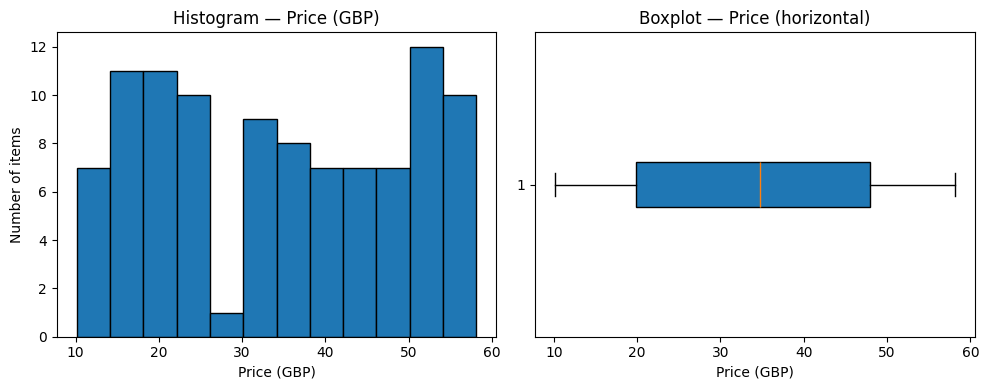

In [4]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

# histogram
plt.subplot(1,2,1)
plt.hist(df_friend["price_gbp"].dropna(), bins=12, edgecolor="black")
plt.xlabel("Price (GBP)")
plt.ylabel("Number of items")
plt.title("Histogram — Price (GBP)")

# horizontal boxplot (distinct style)
plt.subplot(1,2,2)
plt.boxplot(df_friend["price_gbp"].dropna(), vert=False, patch_artist=True)
plt.xlabel("Price (GBP)")
plt.title("Boxplot — Price (horizontal)")

plt.tight_layout()
plt.show()


##Save cleaned CSV

In [5]:

out_name = "friend_clean_books_export.csv"
df_friend.to_csv(out_name, index=False)
print(f"Cleaned file saved as: {out_name}")


Cleaned file saved as: friend_clean_books_export.csv
